In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
import string

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Lambda, BatchNormalization, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten,Dropout, GlobalMaxPooling1D
from tensorflow.keras import layers, utils, callbacks, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tqdm import tqdm

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
train = pd.read_excel('/content/gdrive/MyDrive/Tesis/0.001/Dataset jkt train ner6.xlsx', engine='openpyxl')
train = train.astype(str)
val = pd.read_excel('/content/gdrive/MyDrive/Tesis/0.001/Dataset jkt val ner6.xlsx', engine='openpyxl')
val = val.astype(str)
test = pd.read_excel("/content/gdrive/MyDrive/Tesis/0.001/Dataset test jkt fix ner6.xlsx", engine='openpyxl')
test = test.astype(str)

In [ ]:
train.head()

,Nomer,Perkara,Pihak,Link,Pasal,Kasus,Pasal_Pasangan,Isi,Kemiripan,question1,question2
0,2426,Pembunuhan,"Penuntut Umum:1.Z.M YENI, ROSALITA, SH, MH2.WI...",http://sipp.pn-jakartapusat.go.id/show_detil/V...,351.0,KETIGA :----------Bahwa ia Terdakwa REYHAN AZ...,170.0,(1) Barang siapa dengan terang-terangan dan de...,0,KETIGA PER PER MISC MISC MISC als ORG ORG tang...,Barang terang terangan tenaga kekerasan PER PE...
1,2426,Pembunuhan,"Penuntut Umum:1.Z.M YENI, ROSALITA, SH, MH2.WI...",http://sipp.pn-jakartapusat.go.id/show_detil/V...,351.0,KETIGA :----------Bahwa ia Terdakwa REYHAN AZ...,363.0,(1) Diancam dengan pidana penjara paling lama ...,0,KETIGA PER PER MISC MISC MISC als ORG ORG tang...,Diancam pidana penjara tujuh pencurian ternak ...
2,2426,Pembunuhan,"Penuntut Umum:1.Z.M YENI, ROSALITA, SH, MH2.WI...",http://sipp.pn-jakartapusat.go.id/show_detil/V...,351.0,KETIGA :----------Bahwa ia Terdakwa REYHAN AZ...,362.0,"Barang siapa mengambil barang sesuatu, yang se...",0,KETIGA PER PER MISC MISC MISC als ORG ORG tang...,Barang mengambil barang kepunyaan orang maksud...
3,2426,Pembunuhan,"Penuntut Umum:1.Z.M YENI, ROSALITA, SH, MH2.WI...",http://sipp.pn-jakartapusat.go.id/show_detil/V...,351.0,KETIGA :----------Bahwa ia Terdakwa REYHAN AZ...,372.0,Barang siapa dengan sengaja dan melawan hukum ...,0,KETIGA PER PER MISC MISC MISC als ORG ORG tang...,Barang sengaja melawan hukum memiliki barang P...
4,2426,Pembunuhan,"Penuntut Umum:1.Z.M YENI, ROSALITA, SH, MH2.WI...",http://sipp.pn-jakartapusat.go.id/show_detil/V...,351.0,KETIGA :----------Bahwa ia Terdakwa REYHAN AZ...,303.0,(1) Diancam dengan pidana penjara paling lama ...,0,KETIGA PER PER MISC MISC MISC als ORG ORG tang...,Diancam pidana penjara sepuluh pidana denda pu...


In [ ]:
val.head()

,Nomer,Perkara,Pihak,Link,Pasal,Kasus,Pasal_Pasangan,Isi,Kemiripan,question1,question2
0,1602,Penggelapan,"Penuntut Umum:SILVI MULIANI LESTARI, SH., MHTe...",https://sipptmr.my.id/show_detil/WktQUmpWZk92U...,374.0,Dakwaan :---------Bahwa ia Terdakwa pada ha...,170.0,(1) Barang siapa dengan terang-terangan dan de...,0,PER PER PER tanggal PER sekira jam wib PER sek...,Barang terang terangan tenaga kekerasan PER PE...
1,1602,Penggelapan,"Penuntut Umum:SILVI MULIANI LESTARI, SH., MHTe...",https://sipptmr.my.id/show_detil/WktQUmpWZk92U...,374.0,Dakwaan :---------Bahwa ia Terdakwa pada ha...,363.0,(1) Diancam dengan pidana penjara paling lama ...,0,PER PER PER tanggal PER sekira jam wib PER sek...,Diancam pidana penjara tujuh pencurian ternak ...
2,1602,Penggelapan,"Penuntut Umum:SILVI MULIANI LESTARI, SH., MHTe...",https://sipptmr.my.id/show_detil/WktQUmpWZk92U...,374.0,Dakwaan :---------Bahwa ia Terdakwa pada ha...,362.0,"Barang siapa mengambil barang sesuatu, yang se...",0,PER PER PER tanggal PER sekira jam wib PER sek...,Barang mengambil barang kepunyaan orang maksud...
3,1602,Penggelapan,"Penuntut Umum:SILVI MULIANI LESTARI, SH., MHTe...",https://sipptmr.my.id/show_detil/WktQUmpWZk92U...,374.0,Dakwaan :---------Bahwa ia Terdakwa pada ha...,372.0,Barang siapa dengan sengaja dan melawan hukum ...,0,PER PER PER tanggal PER sekira jam wib PER sek...,Barang sengaja melawan hukum memiliki barang P...
4,1602,Penggelapan,"Penuntut Umum:SILVI MULIANI LESTARI, SH., MHTe...",https://sipptmr.my.id/show_detil/WktQUmpWZk92U...,374.0,Dakwaan :---------Bahwa ia Terdakwa pada ha...,303.0,(1) Diancam dengan pidana penjara paling lama ...,0,PER PER PER tanggal PER sekira jam wib PER sek...,Diancam pidana penjara sepuluh pidana denda pu...


In [ ]:
test.head()

,Nomer,Perkara,Pihak,Link,Pasal,Kasus,Pasal_Pasangan,Isi,Kemiripan,question1,question2
0,4636,Pencurian,"Penuntut Umum:NULI NALI MURTI., SHTerdakwa:ROB...",https://sipp.pn-jakartaselatan.go.id/show_deti...,362.0,-------- Bahwa ia Terdakwa ROBBY TETRA CAHAYA ...,170.0,(1) Barang siapa dengan terang-terangan dan de...,0,PER PER ROBBY TETRA CAHAYA Rabu tanggal PER se...,Barang terang terangan tenaga kekerasan PER PE...
1,4636,Pencurian,"Penuntut Umum:NULI NALI MURTI., SHTerdakwa:ROB...",https://sipp.pn-jakartaselatan.go.id/show_deti...,362.0,-------- Bahwa ia Terdakwa ROBBY TETRA CAHAYA ...,363.0,(1) Diancam dengan pidana penjara paling lama ...,0,PER PER ROBBY TETRA CAHAYA Rabu tanggal PER se...,Diancam pidana penjara tujuh pencurian ternak ...
2,4636,Pencurian,"Penuntut Umum:NULI NALI MURTI., SHTerdakwa:ROB...",https://sipp.pn-jakartaselatan.go.id/show_deti...,362.0,-------- Bahwa ia Terdakwa ROBBY TETRA CAHAYA ...,362.0,"Barang siapa mengambil barang sesuatu, yang se...",1,PER PER ROBBY TETRA CAHAYA Rabu tanggal PER se...,Barang mengambil barang kepunyaan orang maksud...
3,4636,Pencurian,"Penuntut Umum:NULI NALI MURTI., SHTerdakwa:ROB...",https://sipp.pn-jakartaselatan.go.id/show_deti...,362.0,-------- Bahwa ia Terdakwa ROBBY TETRA CAHAYA ...,372.0,Barang siapa dengan sengaja dan melawan hukum ...,0,PER PER ROBBY TETRA CAHAYA Rabu tanggal PER se...,Barang sengaja melawan hukum memiliki barang P...
4,4636,Pencurian,"Penuntut Umum:NULI NALI MURTI., SHTerdakwa:ROB...",https://sipp.pn-jakartaselatan.go.id/show_deti...,362.0,-------- Bahwa ia Terdakwa ROBBY TETRA CAHAYA ...,303.0,(1) Diancam dengan pidana penjara paling lama ...,0,PER PER ROBBY TETRA CAHAYA Rabu tanggal PER se...,Diancam pidana penjara sepuluh pidana denda pu...


# Preprocessing

In [ ]:
#train, test = train_test_split(data, stratify=data.is_duplicate, test_size=0.2)

In [ ]:
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 100

In [ ]:
corpus = []

feats = ['question1','question2']
for f in feats:
    train[f] = train[f].astype(str)
    val[f] = val[f].astype(str)
    test[f] = test[f].astype(str)
    corpus+=train[f].values.tolist()
    corpus+=val[f].values.tolist()
    corpus+=test[f].values.tolist()


tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
X_q1 = tokenizer.texts_to_sequences(train['question1'])
X_q2 = tokenizer.texts_to_sequences(train['question2'])

X_val_q1 = tokenizer.texts_to_sequences(val['question1'])
X_val_q2 = tokenizer.texts_to_sequences(val['question2'])

X_test_q1 = tokenizer.texts_to_sequences(test['question1'])
X_test_q2 = tokenizer.texts_to_sequences(test['question2'])


X_q1 = pad_sequences(X_q1, maxlen=MAX_SEQUENCE_LENGTH)
X_q2 = pad_sequences(X_q2, maxlen=MAX_SEQUENCE_LENGTH)
X_val_q1 = pad_sequences(X_val_q1, maxlen=MAX_SEQUENCE_LENGTH)
X_val_q2 = pad_sequences(X_val_q2, maxlen=MAX_SEQUENCE_LENGTH)
X_test_q1 = pad_sequences(X_test_q1, maxlen=MAX_SEQUENCE_LENGTH)
X_test_q2 = pad_sequences(X_test_q2, maxlen=MAX_SEQUENCE_LENGTH)

#y = train['Kemiripan'].values

word_index = tokenizer.word_index
nb_words = len(word_index)+1

# Word Embedding

In [ ]:
import re, nltk, gensim
# Loading pre-trained word vectors
def load_embedding(EMBEDDING_FILE,embedding_dim):
  word2vec_model = gensim.models.KeyedVectors.\
  load_word2vec_format(EMBEDDING_FILE, binary = True)
  w2v = dict(zip(word2vec_model.index_to_key,\
                 word2vec_model.vectors))

# This will be the embedding matrix
  embeddings = 1 * np.random.randn(len(word_index) \
                                   + 1, embedding_dim)
  embeddings[0] = 0  # So that the padding will be ignored


# Build the embedding matrix
  for word, index in word_index.items():
      if word in word2vec_model.index_to_key:
          embeddings[index] = word2vec_model.get_vector(word)
  return embeddings

embedding_dim=100
EMBEDDING_FILE = '/content/gdrive/MyDrive/Tesis/0.001/fasttext_model_ner_jkt_wiki6.bin'

embeddings=load_embedding(EMBEDDING_FILE,embedding_dim)

In [ ]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
#X_train_q1,X_val_q1,X_train_q2,X_val_q2,y_train,y_val = train_test_split(X_q1,X_q2,y,train_size=0.8,random_state=1024)
print(X_q1.shape,X_val_q1.shape,X_test_q1.shape)
X_train = [X_q1,X_q2]
X_val = [X_val_q1,X_val_q2]
X_test = [X_test_q1,X_test_q2]

(82480, 30) (10300, 30) (10320, 30)


In [ ]:
y_train = train['Kemiripan'].values
y_val = val['Kemiripan'].values
y_test = test['Kemiripan'].values

In [ ]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

## Euclidean distance and Cosine distance

In [ ]:
#Cosine distance
#def cosine_distance(output):
#  x, y= output[0],output[1]
#  x = K.l2_normalize(x, axis=-1)
#  y = K.l2_normalize(y, axis=-1)
#  return -K.mean(x * y, axis=-1, keepdims=True)

def cosine_distance(inputs):
    x, y = inputs
    x = tf.keras.backend.l2_normalize(x, axis=-1)
    y = tf.keras.backend.l2_normalize(y, axis=-1)
    return tf.keras.backend.sum(x * y, axis=-1, keepdims=True)

def euclidean_distance(output):
    x, y = output[0],output[1]
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.metrics import Precision, Recall

# BiLSTM

## DropOut 0.2

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(embedded_sequences_q1)
x1 = Dropout(0.2)(x1)
x2 = lstm_layer(embedded_sequences_q2)
x2 = Dropout(0.2)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model11 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model11.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model11.summary()
utils.plot_model(model11, show_shapes=True, expand_nested=True)
cp11=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_02.hdf5',monitor='val_accuracy',verbose=1,save_best_only=False)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 100)              1699400   ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 516)                  740976    ['embedding_1[0][0]',   

In [ ]:
history_f_bilstm = model11.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp11]
)

Epoch 1/20
2577/2578 [============================>.] - ETA: 0s - loss: 0.2213 - accuracy: 0.9476 - precision_1: 0.0742 - recall_1: 0.0041
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_02.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 38s 12ms/step - loss: 0.2214 - accuracy: 0.9476 - precision_1: 0.0742 - recall_1: 0.0041 - val_loss: 0.1525 - val_accuracy: 0.9517 - val_precision_1: 1.0000 - val_recall_1: 0.0350
Epoch 2/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.9548 - precision_1: 0.9249 - recall_1: 0.1046
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_02.hdf5
2578/2578 [==============================] - 29s 11ms/step - loss: 0.1303 - accuracy: 0.9548 - precision_1: 0.9251 - recall_1: 0.1048 - val_loss: 0.0899 - val_accuracy: 0.9660 - val_precision_1: 0.8000 - val_recall_1: 0.4272
Epoch 3/20
2577/2578 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9721 - precision_1: 0.9102 - recall_1: 0.4915
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_02.hdf5
2578/2578 [==============================] - 29s 11ms/step - loss: 0.0874 

In [ ]:
y_pred_test = model11.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission11 = test.copy()
submission11['Kemiripan'] = submission11['Kemiripan'].astype('float32')
submission11['predict'] = y_pred_test
submission11['predict'] = submission11['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission11.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_bilstm_02.csv',index=False)

323/323 [==============================] - 2s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+BiLSTM+ner 20 Epoch 0.2')
print('---------------------------')
print(classification_report(submission11['Kemiripan'],submission11['predict']))
print('---------------------------')

Model Metrics for FastText+BiLSTM+ner 20 Epoch 0.2
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.79      0.80      0.79       516

    accuracy                           0.98     10320
   macro avg       0.89      0.89      0.89     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission11['Accuracy'] = (submission11['Kemiripan'] == submission11['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission11['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9792635658914729


In [ ]:
submission11 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_bilstm_02.csv')
submission11 = submission11.astype(str)

In [2]:
df = submission11

# Menambahkan kolom baru 'C' sesuai aturan yang diberikan
df['koreksi'] = (df['Kemiripan'] == '1.0') & (df['predict'] == '1.0')

# Mengganti nilai True/False dengan 1/0
df['koreksi'] = df['koreksi'].astype(int)

# Mengurutkan DataFrame berdasarkan kolom 'C' secara descending
df = df.sort_values(by='koreksi', ascending=False)
df = df.astype(str)

import pandas as pd

#df = submission31

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['koreksi']:
            if prediction == '1':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.15350161812297748

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.075262829403606204

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.037359734287174534


## DropOut 0.3

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(embedded_sequences_q1)
x1 = Dropout(0.3)(x1)
x2 = lstm_layer(embedded_sequences_q2)
x2 = Dropout(0.3)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model12 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model12.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model12.summary()
utils.plot_model(model12, show_shapes=True, expand_nested=True)
cp12=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_03.hdf5',monitor='val_accuracy',verbose=1,save_best_only=False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              1699400   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 516)                  740976    ['embedding[0][0]',       

In [ ]:
history_f_bilstm = model12.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp12]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.2173 - accuracy: 0.9463 - precision: 0.0600 - recall: 0.0051
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_03.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 45s 13ms/step - loss: 0.2173 - accuracy: 0.9463 - precision: 0.0600 - recall: 0.0051 - val_loss: 0.1534 - val_accuracy: 0.9544 - val_precision: 0.9245 - val_recall: 0.0951
Epoch 2/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.1375 - accuracy: 0.9552 - precision: 0.8861 - recall: 0.1188
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_03.hdf5
2578/2578 [==============================] - 31s 12ms/step - loss: 0.1375 - accuracy: 0.9552 - precision: 0.8861 - recall: 0.1188 - val_loss: 0.0961 - val_accuracy: 0.9666 - val_precision: 0.7256 - val_recall: 0.5340
Epoch 3/20
2574/2578 [============================>.] - ETA: 0s - loss: 0.0942 - accuracy: 0.9675 - precision: 0.8879 - recall: 0.4001
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_03.hdf5
2578/2578 [==============================] - 30s 12ms/step - loss: 0.0942 - accuracy: 0.9675 - pre

In [ ]:
from tensorflow.keras.models import load_model

# load model
model12 = load_model('/content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_03.hdf5')

In [ ]:
y_pred_test = model12.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission12 = test.copy()
submission12['Kemiripan'] = submission12['Kemiripan'].astype('float32')
submission12['predict'] = y_pred_test
submission12['predict'] = submission12['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission12.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_bilstm_03.csv',index=False)

323/323 [==============================] - 3s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+BiLSTM+ner 20 Epoch 0.3')
print('---------------------------')
print(classification_report(submission12['Kemiripan'],submission12['predict']))
print('---------------------------')

Model Metrics for FastText+BiLSTM+ner 20 Epoch 0.3
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.76      0.82      0.79       516

    accuracy                           0.98     10320
   macro avg       0.87      0.90      0.89     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission12['Accuracy'] = (submission12['Kemiripan'] == submission12['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission12['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9778100775193799


In [ ]:
# Tampilkan hanya kolom 'Nama' dan 'Usia'
selected_columns = submission12[['Perkara', 'Pasal', 'Kasus', 'Pasal_Pasangan', 'Isi', 'Kemiripan', 'predict']]
selected_rows = selected_columns.iloc[82:85]
selected_rows

,Perkara,Pasal,Kasus,Pasal_Pasangan,Isi,Kemiripan,predict
82,Penggelapan,372.0,PERTAMA : --------- Bahwa ia terdakwa Her...,362.0,"Barang siapa mengambil barang sesuatu, yang se...",0.0,0.0
83,Penggelapan,372.0,PERTAMA : --------- Bahwa ia terdakwa Her...,372.0,Barang siapa dengan sengaja dan melawan hukum ...,1.0,1.0
84,Penggelapan,372.0,PERTAMA : --------- Bahwa ia terdakwa Her...,303.0,(1) Diancam dengan pidana penjara paling lama ...,0.0,0.0


In [ ]:
# Tampilkan hanya kolom 'Nama' dan 'Usia'
selected_columns = submission12[['Perkara', 'Pasal', 'Kasus', 'Pasal_Pasangan', 'Isi', 'Kemiripan', 'predict']]
selected_rows = selected_columns.iloc[188:190]
selected_rows

,Perkara,Pasal,Kasus,Pasal_Pasangan,Isi,Kemiripan,predict
188,Penganiayaan,351.0,"Bahwa ia Terdakwa AGUNG SETIAWAN Bin MAKMUR, p...",351.0,(1) Penganiayaan diancam dengan pidana penjara...,1.0,1.0
189,Penganiayaan,351.0,"Bahwa ia Terdakwa AGUNG SETIAWAN Bin MAKMUR, p...",365.0,(1) Diancam dengan pidana penjara paling lama ...,0.0,0.0


In [ ]:
submission12 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_bilstm_03.csv')
submission12 = submission12.astype(str)

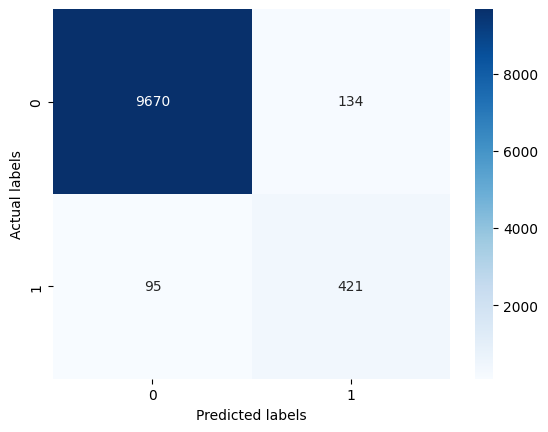

In [ ]:
actual_labels = submission12['Kemiripan']  # Replace 'actual_column_name' with your actual column name
predicted_labels = submission12['predict']

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(actual_labels, predicted_labels)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [ ]:
import pandas as pd

df = submission12

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.05948220064724934

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.03427423331792275

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.017138777364122337



## DropOut 0.5

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(embedded_sequences_q1)
x1 = Dropout(0.5)(x1)
x2 = lstm_layer(embedded_sequences_q2)
x2 = Dropout(0.5)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model13 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model13.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model13.summary()
utils.plot_model(model13, show_shapes=True, expand_nested=True)
cp13=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_05.hdf5',monitor='val_accuracy',verbose=1,save_best_only=False)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 30, 100)              1699400   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 516)                  740976    ['embedding_2[0][0]',   

In [ ]:
history_f_bilstm = model13.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp13]
)

Epoch 1/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.2529 - accuracy: 0.9464 - precision_2: 0.0491 - recall_2: 0.0039
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_05.hdf5
2578/2578 [==============================] - 51s 18ms/step - loss: 0.2529 - accuracy: 0.9464 - precision_2: 0.0491 - recall_2: 0.0039 - val_loss: 0.1769 - val_accuracy: 0.9500 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/20
   3/2578 [..............................] - ETA: 1:07 - loss: 0.2264 - accuracy: 0.9271 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2574/2578 [============================>.] - ETA: 0s - loss: 0.1719 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_05.hdf5
2578/2578 [==============================] - 38s 15ms/step - loss: 0.1719 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.1459 - val_accuracy: 0.9541 - val_precision_2: 0.6040 - val_recall_2: 0.2369
Epoch 3/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.9503 - precision_2: 0.9394 - recall_2: 0.0075
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_05.hdf5
2578/2578 [==============================] - 37s 15ms/step - loss: 0.1368 - accuracy: 0.9504 - precision_2: 0.9394 - recall_2: 0.0075 - val_loss: 0.0972 - val_accuracy: 0.9663 - val_precision_2: 0.6944 - val_recall_2: 0.5825
Epoch 4/20
2577/2578 [============================>.] - ETA: 0s - los

In [ ]:
y_pred_test = model13.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission13 = test.copy()
submission13['Kemiripan'] = submission13['Kemiripan'].astype('float32')
submission13['predict'] = y_pred_test
submission13['predict'] = submission13['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission13.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_bilstm_05.csv',index=False)

323/323 [==============================] - 3s 5ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+BiLSTM+ner 20 Epoch 0.5')
print('---------------------------')
print(classification_report(submission13['Kemiripan'],submission13['predict']))
print('---------------------------')

Model Metrics for FastText+BiLSTM+ner 20 Epoch 0.5
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      9804
         1.0       0.62      0.89      0.73       516

    accuracy                           0.97     10320
   macro avg       0.81      0.93      0.86     10320
weighted avg       0.98      0.97      0.97     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission13['Accuracy'] = (submission13['Kemiripan'] == submission13['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission13['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9668604651162791


In [ ]:
submission13 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_bilstm_05.csv')
submission13 = submission13.astype(str)

In [ ]:
import pandas as pd

df = submission13

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.0825631067961167

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.04671944829711826

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.023430024849307843



## DropOut 0.7

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(embedded_sequences_q1)
x1 = Dropout(0.7)(x1)
x2 = lstm_layer(embedded_sequences_q2)
x2 = Dropout(0.7)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model14 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model14.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model14.summary()
utils.plot_model(model14, show_shapes=True, expand_nested=True)
cp14=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_07.hdf5',monitor='val_accuracy',verbose=1,save_best_only=False)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 30, 100)              1699400   ['input_7[0][0]',             
                                                                     'input_8[0][0]']             
                                                                                                  
 bidirectional_3 (Bidirecti  (None, 516)                  740976    ['embedding_3[0][0]',   

In [ ]:
history_f_bilstm = model14.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp14]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_07.hdf5
2578/2578 [==============================] - 50s 16ms/step - loss: 0.3230 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.2106 - val_accuracy: 0.9500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/20
   6/2578 [..............................] - ETA: 28s - loss: 0.2436 - accuracy: 0.9375 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2574/2578 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_07.hdf5
2578/2578 [==============================] - 39s 15ms/step - loss: 0.2028 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.2430 - val_accuracy: 0.9500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/20
2578/2578 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_f_ner_train_20ep_07.hdf5
2578/2578 [==============================] - 38s 15ms/step - loss: 0.1985 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.2466 - val_accuracy: 0.9500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/20
2574/2578 [===============

In [ ]:
y_pred_test = model14.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission14 = test.copy()
submission14['Kemiripan'] = submission14['Kemiripan'].astype('float32')
submission14['predict'] = y_pred_test
submission14['predict'] = submission14['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission14.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_bilstm_07.csv',index=False)

323/323 [==============================] - 3s 5ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+BiLSTM+ner 20 Epoch 0.7')
print('---------------------------')
print(classification_report(submission14['Kemiripan'],submission14['predict']))
print('---------------------------')

Model Metrics for FastText+BiLSTM+ner 20 Epoch 0.7
---------------------------
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      9804
         1.0       0.00      0.00      0.00       516

    accuracy                           0.95     10320
   macro avg       0.47      0.50      0.49     10320
weighted avg       0.90      0.95      0.93     10320

---------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Assign values to Accuracy column based on conditions
submission14['Accuracy'] = (submission14['Kemiripan'] == submission14['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission14['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.95


In [ ]:
submission14 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_bilstm_07.csv')
submission14 = submission14.astype(str)

In [ ]:
import pandas as pd

df = submission14

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.0

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.0

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.0



# CNN

## Kernel 2

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 2
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Apply Global Max Pooling to reduce the dimensionality
x1 = GlobalMaxPooling1D()(x1)
x2 = GlobalMaxPooling1D()(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model21 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model21.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model21.summary()
utils.plot_model(model21, show_shapes=True, expand_nested=True)
cp21=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_2.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 30, 100)              1699400   ['input_9[0][0]',             
                                                                     'input_10[0][0]']            
                                                                                                  
 conv1d (Conv1D)             (None, 29, 258)              51858     ['embedding_4[0][0]',   

In [ ]:
history_f_cnn = model21.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp21]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9500 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_2.hdf5
2578/2578 [==============================] - 25s 7ms/step - loss: 0.2560 - accuracy: 0.9500 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.1793 - val_accuracy: 0.9500 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/20
  22/2578 [..............................] - ETA: 12s - loss: 0.1770 - accuracy: 0.9489 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2572/2578 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9500 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_2.hdf5
2578/2578 [==============================] - 17s 6ms/step - loss: 0.1622 - accuracy: 0.9500 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.1500 - val_accuracy: 0.9500 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/20
2574/2578 [============================>.] - ETA: 0s - loss: 0.1411 - accuracy: 0.9500 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_2.hdf5
2578/2578 [==============================] - 19s 7ms/step - loss: 0.1410 - accuracy: 0.9500 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 0.1339 - val_accuracy: 0.9500 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 4/20
2573/2578 [=========================

In [ ]:
y_pred_test = model21.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission21 = test.copy()
submission21['Kemiripan'] = submission21['Kemiripan'].astype('float32')
submission21['predict'] = y_pred_test
submission21['predict'] = submission21['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission21.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnn_2.csv',index=False)

323/323 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+CNN+ner 20 Epoch 2')
print('---------------------------')
print(classification_report(submission21['Kemiripan'],submission21['predict']))
print('---------------------------')

Model Metrics for FastText+CNN+ner 20 Epoch 2
---------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      9804
         1.0       0.65      0.64      0.64       516

    accuracy                           0.96     10320
   macro avg       0.81      0.81      0.81     10320
weighted avg       0.96      0.96      0.96     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission21['Accuracy'] = (submission21['Kemiripan'] == submission21['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission21['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9645348837209302


In [ ]:
submission21 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnn_2.csv')
submission21 = submission21.astype(str)

In [ ]:
import pandas as pd

df = submission21

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.06393527508090632

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.03549714902142098

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.017762972298440805



## Kernel 3

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 3
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Apply Global Max Pooling to reduce the dimensionality
x1 = GlobalMaxPooling1D()(x1)
x2 = GlobalMaxPooling1D()(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model22 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model22.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model22.summary()
utils.plot_model(model22, show_shapes=True, expand_nested=True)
cp22=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_3.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 30, 100)              1699400   ['input_11[0][0]',            
                                                                     'input_12[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 258)              77658     ['embedding_5[0][0]',   

In [ ]:
history_f_cnn = model22.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp22]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_3.hdf5
2578/2578 [==============================] - 20s 7ms/step - loss: 0.2251 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.1702 - val_accuracy: 0.9500 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/20
  21/2578 [..............................] - ETA: 13s - loss: 0.1417 - accuracy: 0.9643 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2572/2578 [============================>.] - ETA: 0s - loss: 0.1526 - accuracy: 0.9501 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_3.hdf5
2578/2578 [==============================] - 18s 7ms/step - loss: 0.1527 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.1420 - val_accuracy: 0.9500 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/20
2577/2578 [============================>.] - ETA: 0s - loss: 0.1321 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_3.hdf5
2578/2578 [==============================] - 17s 7ms/step - loss: 0.1321 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.1240 - val_accuracy: 0.9500 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/20
2574/2578 [=========================

In [ ]:
y_pred_test = model22.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission22 = test.copy()
submission22['Kemiripan'] = submission22['Kemiripan'].astype('float32')
submission22['predict'] = y_pred_test
submission22['predict'] = submission22['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission22.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnn_3.csv',index=False)

323/323 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+CNN+ner 20 Epoch 3')
print('---------------------------')
print(classification_report(submission22['Kemiripan'],submission22['predict']))
print('---------------------------')

Model Metrics for FastText+CNN+ner 20 Epoch 3
---------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9804
         1.0       0.78      0.66      0.71       516

    accuracy                           0.97     10320
   macro avg       0.88      0.82      0.85     10320
weighted avg       0.97      0.97      0.97     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission22['Accuracy'] = (submission22['Kemiripan'] == submission22['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission22['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.973546511627907


In [ ]:
submission22 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnn_3.csv')
submission22 = submission22.astype(str)

In [ ]:
import pandas as pd

df = submission22

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.050957928802589106

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.028777931884728082

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.014388965942364041



## Kernel 4

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 4
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Apply Global Max Pooling to reduce the dimensionality
x1 = GlobalMaxPooling1D()(x1)
x2 = GlobalMaxPooling1D()(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model23 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model23.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model23.summary()
utils.plot_model(model23, show_shapes=True, expand_nested=True)
cp23=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_4.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 30, 100)              1699400   ['input_13[0][0]',            
                                                                     'input_14[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 27, 258)              103458    ['embedding_6[0][0]',   

In [ ]:
history_f_cnn = model23.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp23]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.9478 - precision_6: 0.4343 - recall_6: 0.1467
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_4.hdf5
2578/2578 [==============================] - 19s 6ms/step - loss: 0.3786 - accuracy: 0.9478 - precision_6: 0.4343 - recall_6: 0.1467 - val_loss: 0.2193 - val_accuracy: 0.9500 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/20
  17/2578 [..............................] - ETA: 16s - loss: 0.2575 - accuracy: 0.9246 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2573/2578 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9499 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_4.hdf5
2578/2578 [==============================] - 18s 7ms/step - loss: 0.1722 - accuracy: 0.9500 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 0.1445 - val_accuracy: 0.9500 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/20
2573/2578 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.9587 - precision_6: 0.8542 - recall_6: 0.2118
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_4.hdf5
2578/2578 [==============================] - 16s 6ms/step - loss: 0.1200 - accuracy: 0.9588 - precision_6: 0.8545 - recall_6: 0.2122 - val_loss: 0.1077 - val_accuracy: 0.9679 - val_precision_6: 0.8966 - val_recall_6: 0.4039
Epoch 4/20
2578/2578 [==============================] - ETA: 0s - loss:

In [ ]:
y_pred_test = model23.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission23 = test.copy()
submission23['Kemiripan'] = submission23['Kemiripan'].astype('float32')
submission23['predict'] = y_pred_test
submission23['predict'] = submission23['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission23.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnn_4.csv',index=False)

323/323 [==============================] - 1s 3ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+CNN+ner 20 Epoch 4')
print('---------------------------')
print(classification_report(submission23['Kemiripan'],submission23['predict']))
print('---------------------------')

Model Metrics for FastText+CNN+ner 20 Epoch 4
---------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9804
         1.0       0.84      0.63      0.72       516

    accuracy                           0.98     10320
   macro avg       0.91      0.81      0.85     10320
weighted avg       0.97      0.98      0.97     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission23['Accuracy'] = (submission23['Kemiripan'] == submission23['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission23['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.975484496124031


In [ ]:
submission23 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnn_4.csv')
submission23 = submission23.astype(str)

In [ ]:
import pandas as pd

df = submission23

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.04087378640776702

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.02403652334720299

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.012018900406355712



## Kernel 5

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 5
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Apply Global Max Pooling to reduce the dimensionality
x1 = GlobalMaxPooling1D()(x1)
x2 = GlobalMaxPooling1D()(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model24 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model24.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model24.summary()
utils.plot_model(model24, show_shapes=True, expand_nested=True)
cp24=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_5.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 30, 100)              1699400   ['input_15[0][0]',            
                                                                     'input_16[0][0]']            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 26, 258)              129258    ['embedding_7[0][0]',   

In [ ]:
history_f_cnn = model24.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp24]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.9460 - precision_7: 0.2788 - recall_7: 0.0500
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_5.hdf5
2578/2578 [==============================] - 20s 7ms/step - loss: 0.3795 - accuracy: 0.9460 - precision_7: 0.2788 - recall_7: 0.0500 - val_loss: 0.2218 - val_accuracy: 0.9500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/20
  21/2578 [..............................] - ETA: 13s - loss: 0.2201 - accuracy: 0.9509 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2576/2578 [============================>.] - ETA: 0s - loss: 0.1771 - accuracy: 0.9500 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_5.hdf5
2578/2578 [==============================] - 18s 7ms/step - loss: 0.1770 - accuracy: 0.9500 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 0.1410 - val_accuracy: 0.9500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.1263 - accuracy: 0.9584 - precision_7: 0.9214 - recall_7: 0.1848
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_f_ner_train_20ep_5.hdf5
2578/2578 [==============================] - 17s 7ms/step - loss: 0.1263 - accuracy: 0.9585 - precision_7: 0.9214 - recall_7: 0.1848 - val_loss: 0.1100 - val_accuracy: 0.9676 - val_precision_7: 0.8291 - val_recall_7: 0.4427
Epoch 4/20
2576/2578 [============================>.] - ETA: 0s - loss:

In [ ]:
y_pred_test = model24.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission24 = test.copy()
submission24['Kemiripan'] = submission24['Kemiripan'].astype('float32')
submission24['predict'] = y_pred_test
submission24['predict'] = submission24['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission24.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnn_5.csv',index=False)

323/323 [==============================] - 1s 3ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+CNN+ner 20 Epoch 5')
print('---------------------------')
print(classification_report(submission24['Kemiripan'],submission24['predict']))
print('---------------------------')

Model Metrics for FastText+CNN+ner 20 Epoch 5
---------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9804
         1.0       0.84      0.68      0.76       516

    accuracy                           0.98     10320
   macro avg       0.91      0.84      0.87     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission24['Accuracy'] = (submission24['Kemiripan'] == submission24['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission24['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9778100775193799


In [ ]:
submission24 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnn_5.csv')
submission24 = submission24.astype(str)

In [ ]:
import pandas as pd

df = submission24

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.04385113268608418

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.02574657112035756

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.01287328556017878



# CNN-BiLSTM

## Kernel 2 DropOut 0.2

In [ ]:
from tensorflow.keras.layers import concatenate

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 2
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(x1)
x1 = Dropout(0.2)(x1)
x2 = lstm_layer(x2)
x2 = Dropout(0.2)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model31 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model31.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model31.summary()
utils.plot_model(model31, show_shapes=True, expand_nested=True)
cp31=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_2_02.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              1699400   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 29, 258)              51858     ['embedding[0][0]',       

In [ ]:
history_f_cnnbilstm = model31.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp31]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9470 - precision: 0.0690 - recall: 0.0048
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_2_02.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 49s 12ms/step - loss: 0.2157 - accuracy: 0.9470 - precision: 0.0690 - recall: 0.0048 - val_loss: 0.1676 - val_accuracy: 0.9516 - val_precision: 1.0000 - val_recall: 0.0311
Epoch 2/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9573 - precision: 0.9267 - recall: 0.1594
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_2_02.hdf5
2578/2578 [==============================] - 30s 11ms/step - loss: 0.1320 - accuracy: 0.9573 - precision: 0.9267 - recall: 0.1593 - val_loss: 0.0885 - val_accuracy: 0.9735 - val_precision: 0.8645 - val_recall: 0.5573
Epoch 3/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.0830 - accuracy: 0.9755 - precision: 0.9258 - recall: 0.5542
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_2_02.hdf5
2578/2578 [==============================] - 30s 11ms/step - loss: 0.0830 - accuracy: 

In [ ]:
y_pred_test = model31.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission31 = test.copy()
submission31['Kemiripan'] = submission31['Kemiripan'].astype('float32')
submission31['predict'] = y_pred_test
submission31['predict'] = submission31['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission31.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnnbilstm_2_02.csv',index=False)

323/323 [==============================] - 3s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+CNN-BiLSTM+ner 20 Epoch 2 0.2')
print('---------------------------')
print(classification_report(submission31['Kemiripan'],submission31['predict']))
print('---------------------------')

Model Metrics for FastText+CNN-BiLSTM+ner 20 Epoch 2 0.2
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.82      0.82      0.82       516

    accuracy                           0.98     10320
   macro avg       0.90      0.90      0.90     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission31['Accuracy'] = (submission31['Kemiripan'] == submission31['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission31['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9816860465116279


In [ ]:
submission31 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnnbilstm_2_02.csv')
submission31 = submission31.astype(str)

In [ ]:
import pandas as pd

df = submission31

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.05684142394822022

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.03275104022191412

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.0163803744798891



## Kernel 3 DropOut 0.3

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 3
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(x1)
x1 = Dropout(0.3)(x1)
x2 = lstm_layer(x2)
x2 = Dropout(0.3)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model32 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model32.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model32.summary()
utils.plot_model(model32, show_shapes=True, expand_nested=True)
cp32=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_3_03.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 100)              1699400   ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 258)              77658     ['embedding_1[0][0]',   

In [ ]:
history_f_cnnbilstm = model32.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp32]
)

Epoch 1/20
2577/2578 [============================>.] - ETA: 0s - loss: 0.2434 - accuracy: 0.9500 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_3_03.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 37s 12ms/step - loss: 0.2433 - accuracy: 0.9500 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.1832 - val_accuracy: 0.9500 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20
2575/2578 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9500 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_3_03.hdf5
2578/2578 [==============================] - 29s 11ms/step - loss: 0.1717 - accuracy: 0.9500 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.1446 - val_accuracy: 0.9500 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/20
2575/2578 [============================>.] - ETA: 0s - loss: 0.1409 - accuracy: 0.9509 - precision_1: 0.8491 - recall_1: 0.0218
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_3_03.hdf5
2578/2578 [===========

In [ ]:
y_pred_test = model32.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission32 = test.copy()
submission32['Kemiripan'] = submission32['Kemiripan'].astype('float32')
submission32['predict'] = y_pred_test
submission32['predict'] = submission32['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission32.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnnbilstm_3_03.csv',index=False)

323/323 [==============================] - 2s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+CNN-BiLSTM 20 Epoch 3 0.3')
print('---------------------------')
print(classification_report(submission32['Kemiripan'],submission32['predict']))
print('---------------------------')

Model Metrics for FastText+CNN-BiLSTM 20 Epoch 3 0.3
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.78      0.79      0.79       516

    accuracy                           0.98     10320
   macro avg       0.88      0.89      0.89     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission32['Accuracy'] = (submission32['Kemiripan'] == submission32['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission32['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9782945736434109


In [ ]:
submission32 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnnbilstm_3_03.csv')
submission32 = submission32.astype(str)

In [ ]:
import pandas as pd

df = submission32

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.054220064724919234

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.03179603945137935

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.015901383718195213



## Kernel 4 DropOut 0.5

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 4
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(x1)
x1 = Dropout(0.5)(x1)
x2 = lstm_layer(x2)
x2 = Dropout(0.5)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model33 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model33.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model33.summary()
utils.plot_model(model33, show_shapes=True, expand_nested=True)
cp33=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_4_05.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 30, 100)              1699400   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 27, 258)              103458    ['embedding_2[0][0]',   

In [ ]:
history_f_cnnbilstm = model33.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp33]
)

Epoch 1/20
2577/2578 [============================>.] - ETA: 0s - loss: 0.2614 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_4_05.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 36s 12ms/step - loss: 0.2614 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.2100 - val_accuracy: 0.9500 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.1978 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_4_05.hdf5
2578/2578 [==============================] - 29s 11ms/step - loss: 0.1978 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.2267 - val_accuracy: 0.9500 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/20
2575/2578 [============================>.] - ETA: 0s - loss: 0.1969 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_4_05.hdf5
2578/2578 [===

In [ ]:
y_pred_test = model33.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission33 = test.copy()
submission33['Kemiripan'] = submission33['Kemiripan'].astype('float32')
submission33['predict'] = y_pred_test
submission33['predict'] = submission33['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission33.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnnbilstm_4_05.csv',index=False)

323/323 [==============================] - 2s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+CNN-BiLSTM+ner 20 Epoch 4 0.5')
print('---------------------------')
print(classification_report(submission33['Kemiripan'],submission33['predict']))
print('---------------------------')

Model Metrics for FastText+CNN-BiLSTM+ner 20 Epoch 4 0.5
---------------------------
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      9804
         1.0       0.00      0.00      0.00       516

    accuracy                           0.95     10320
   macro avg       0.47      0.50      0.49     10320
weighted avg       0.90      0.95      0.93     10320

---------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Assign values to Accuracy column based on conditions
submission33['Accuracy'] = (submission33['Kemiripan'] == submission33['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission33['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.95


In [ ]:
submission33 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnnbilstm_4_05.csv')
submission33 = submission33.astype(str)

In [ ]:
import pandas as pd

df = submission33

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.0

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.0

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.0



## Kernel 5 DropOut 0.7

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 5
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(x1)
x1 = Dropout(0.7)(x1)
x2 = lstm_layer(x2)
x2 = Dropout(0.7)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model34 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model34.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model34.summary()
utils.plot_model(model34, show_shapes=True, expand_nested=True)
cp34=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_5_07.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 30, 100)              1699400   ['input_7[0][0]',             
                                                                     'input_8[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 26, 258)              129258    ['embedding_3[0][0]',   

In [ ]:
history_f_cnnbilstm = model34.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp34]
)

Epoch 1/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.3182 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_5_07.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 35s 11ms/step - loss: 0.3183 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.2133 - val_accuracy: 0.9500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_5_07.hdf5
2578/2578 [==============================] - 28s 11ms/step - loss: 0.2028 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.2471 - val_accuracy: 0.9500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/20
2578/2578 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_f_ner_train_20ep_5_07.hdf5
2578/2578 [===

In [ ]:
y_pred_test = model34.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission34 = test.copy()
submission34['Kemiripan'] = submission34['Kemiripan'].astype('float32')
submission34['predict'] = y_pred_test
submission34['predict'] = submission34['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission34.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnnbilstm_5_07.csv',index=False)

323/323 [==============================] - 2s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for FastText+CNN-BiLSTM+ner 20 Epoch 5 0.7')
print('---------------------------')
print(classification_report(submission34['Kemiripan'],submission34['predict']))
print('---------------------------')

Model Metrics for FastText+CNN-BiLSTM+ner 20 Epoch 5 0.7
---------------------------
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      9804
         1.0       0.00      0.00      0.00       516

    accuracy                           0.95     10320
   macro avg       0.47      0.50      0.49     10320
weighted avg       0.90      0.95      0.93     10320

---------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Assign values to Accuracy column based on conditions
submission34['Accuracy'] = (submission34['Kemiripan'] == submission34['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission34['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.95


In [ ]:
submission34 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_f_ner_cnnbilstm_5_07.csv')
submission34 = submission34.astype(str)

In [ ]:
import pandas as pd

df = submission34

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['predict']:
            if prediction == '1.0':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0.0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.0

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.0

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.0

